In [2]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

In [28]:
# import
import os
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.io import ascii

from specdb import query_catalog as spqcat
#from specdb import interface_db as spgidb
from specdb import utils as spdbu
from specdb.specdb import SpecDB, IgmSpec
from specdb import specdb as sdbsdb

from pyigm.surveys.llssurvey import LLSSurvey

from linetools.spectra.xspectrum1d import XSpectrum1D

import importlib
import random
import math

import matplotlib.pyplot as plt

import pickle

import scipy.stats
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit
from collections import Counter

import glob


from funcs import plot_fit, get_meta, get_z, get_BI

In [3]:
def degtodegms(c):
    deg,cc=divmod(c,1)
    m,s=divmod(cc*60,1)
    return '{:.0f}° {:.0f}\' {:.1f}\'\''.format(deg,m,s)

def degtohms(c):
    h,cc=divmod(c/360*24,1)
    m,s=divmod(cc*60,1)
    return '{:.0f}h {:.0f}\' {:.1f}\'\''.format(h,m,s)

rpath='/home/bartosz/Projects/BOSS/'

In [4]:
#db_file=os.getenv('IGMSPEC_DB')
#igmsp = SpecDB(db_file=os.getenv('IGMSPEC_DB')+'/IGMspec_DB_v03.1.hdf5')
igmsp = SpecDB('/media/bartosz/Volume/igmspec_data/DB/IGMspec_DB_v03.1.hdf5')

#importlib.reload(sdbsdb)
#igmsp = sdbsdb.IgmSpec(db_file='/media/bartosz/Volume/igmspec_data/DB/IGMspec_DB_v03.1.hdf5')

Database is igmspec
Created on 2019-Mar-06
Version: v03.1


In [5]:
igmsp.qcat

<QueryCatalog:  Catalog has 547679 sources
   Loaded groups are ['BOSS_DR14', 'SQUAD_DR1', 'ESI_z6', 'KODIAQ_DR2', 'SDSS_DR7', 'KODIAQ_DR1', 'HD-LLS_DR1', 'GGG', 'HST_z2', 'XQ-100', 'HDLA100', '2QZ', 'ESI_DLA', 'COS-Halos', 'COS-Dwarfs', 'HSTQSO', 'MUSoDLA', 'UVES_Dall', 'UVpSM4'] 
>

In [5]:
meta = igmsp['BOSS_DR14'].meta

#index_z = [i for i,entry in enumerate(meta) if 2<= entry[6] <= 3]
#print(len(index_z))

#qdict = { 'Z':(2,3)}
#meta_z = igmsp.query_meta(qdict)
#print(len(meta_z))
#meta_z[0:3]

In [84]:
coords = SkyCoord(meta[35834][0], meta[35834][1],unit='deg')
print(coords)
meta_sing = igmsp.meta_from_position(coords, 1*u.arcsec)
print('-----')
spec = igmsp.spectra_from_meta(meta_sing)
print('Nspec = {:d}'.format(spec.nspec))

print(spec.select)
spec.__dict__.keys()
meta_sing



<SkyCoord (ICRS): (ra, dec) in deg
    (14.2508173, 14.62716282)>
Your search yielded 1 match[es] within radius=1 arcsec
-----
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.0032 Gb
Loaded spectra
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Nspec = 3
0


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


RA_GROUP,DEC_GROUP,THING_ID,PLATE,MJD,FIBERID,Z,Z_ERR,Z_VI,Z_PIPE,Z_PIPE_ERR,ZWARNING,Z_PCA,Z_PCA_ER,Z_MGII,BOSS_TARGET1,ANCILLARY_TARGET1,ANCILLARY_TARGET2,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,N_SPEC_SDSS,N_SPEC_BOSS,N_SPEC,PLATE_DUPLICATE,MJD_DUPLICATE,FIBERID_DUPLICATE,BI_CIV,ERR_BI_CIV,RUN_NUMBER,COL_NUMBER,FIELD_NUMBER,PSFFLUX,IVAR_PSFFLUX,PSFMAG,ERR_PSFMAG,MI,GAL_EXT,RASS_COUNTS,RASS_COUNTS_SNR,SDSS2ROSAT_SEP,FLUX_0.2_2.0keV,FLUX_0.2_2.0keV_ERR,FLUX_2.0_12.0keV,FLUX_2.0_12.0keV_ERR,FLUX_0.2_12.0keV,FLUX_0.2_12.0keV_ERR,LUM_0.2_12.0keV,SDSS2XMM_SEP,GALEX_MATCHED,FUV,FUV_IVAR,NUV,NUV_IVAR,JMAG,ERR_JMAG,JSNR,JRDFLAG,HMAG,ERR_HMAG,HSNR,HRDFLAG,KMAG,ERR_KMAG,KSNR,KRDFLAG,SDSS2MASS_SEP,W1MAG,ERR_W1MAG,W1SNR,W1CHI2,W2MAG,ERR_W2MAG,W2SNR,W2CHI2,W3MAG,ERR_W3MAG,W3SNR,W3CHI2,W4MAG,ERR_W4MAG,W4SNR,W4CHI2,SDSS2WISE_SEP,UKIDSS_MATCHED,YFLUX,YFLUX_ERR,JFLUX,JFLUX_ERR,HFLUX,HFLUX_ERR,KFLUX,KFLUX_ERR,FIRST_MATCHED,FIRST_FLUX,FIRST_SNR,SDSS2FIRST_SEP,ORIG_ID,R,zem_GROUP,sig_zem,IGM_ID,NPIX,WV_MIN,WV_MAX,GROUP_ID,EPOCH,SDSS_NAME,SPECTRO,SOURCE_Z,SPECTRO_DUPLICATE,RERUN_NUMBER,OBJ_ID,CC_FLAGS,PH_FLAGS,flag_zem,CAT,DATE-OBS,INSTR,DISPERSER,TELESCOPE,STYPE,SPEC_FILE,GROUP,UMAG,UMAGERR,GMAG,GMAGERR,RMAG,RMAGERR,IMAG,IMAGERR,ZMAG,ZMAGERR,AU,logNH,FIRSTMAG,FIRSTSN,FIRSTDEL,RASSCNT,RASSSN,RASSDEL,JMAGERR,HMAGERR,KMAGERR,MASSDEL,MASSFLG,MIMAG,DGMI,MFLAG,SPFLAG,MODEFLAG,USELFLAG,BESTFLAG,LZFLAG,HZFLAG,FTFLAG,RTFLAG,SRFLAG,STFLAG,GXFLAG,RUN,RMJD,SMJD,FIBER,RERUN,CAMCOL,FIELD,OBJECT,TFLAG,LZTFLAG,HZTFLAG,FTTFLAG,RTTFLAG,SRTFLAG,STTFLAG,GXTFLAG,UTMAG,UTMAGERR,GTMAG,GTMAGERR,RTMAG,RTMAGERR,ITMAG,ITMAGERR,ZTMAG,ZTMAGERR,SDSSJ,BESTID,SPECOID,ONAME,kodetime,kodwblue,kodwred,kodrelease,qso,sRA,sDEC,pi_date,spec_prefix,redux_setup,targname,deckname,elaptime,qaflag
float64,float64,int32,int32,int32,int16,float64,float64,float64,float64,float64,int16,float64,float64,float64,int64,int64,int64,int64,int64,int64,int16,int16,int16,int32[51],int32[51],int32[51],float64,float64,int16,int16,int16,float64[5],float64[5],float64[5],float64[5],float64,float64[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float32,int16,float64,float64,float32,int16,float64,float64,float32,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,int64,float64,str18,str4,str4,str1[51],str1,str1,str4,str4,str10,str4,str10,str5,str4,str10,str3,str28,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str31,str31,str31,str31,int64,int64,int64,int64,str14,str11,str12,str27,str20,str8,str14,str2,str18,str4
14.25082,14.62716,241804816,5704,56187,310,2.6489999999999996,0.0,2.6489999294281006,2.623656988143921,0.00016750801296439022,0,2.6447656000000004,-1.0,-1.0,4096,0,0,0,0,0,1,0,1,0 .. -1,0 .. -1,0 .. -1,0.0,0.0,0,0,0,34.999515533447266 .. 127.46582794189453,3.1231186389923096 .. 0.15777859091758728,18.639827728271484 .. 17.236478805541992,0.017553113400936127 .. 0.021442590281367302,-29.088345,0.22029274702072144 .. 0.06563570350408554,0.0,0.0,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,1.0,0.19351951777935028,47.8953549783179,4.703124046325684,6.289234720912008,16.276,0.098,11.1,2,15.708,0.157,8.1,2,15.071,0.114,9.4,2,0.136098,14.324000000000002,0.028,38.79999923706055,1.531,13.359000000000002,0.032,33.400001525878906,0.991,9.664,0.048,22.5,0.8903,7.43,0

In [97]:
spec, meta = igmsp.spectra_from_ID(35834)
meta[0][['GROUP']][0]=='BOSS_DR14'

Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.0032 Gb
Loaded spectra
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


True

In [75]:
meta_sing[0][26]

masked_array(data=[0, 119, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
                   -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
                   -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
                   -1, -1, -1, -1, -1, -1, -1, -1, -1],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_value=999999,
            dtype=int32)

In [79]:
for i,m in enumerate(meta):
    radec = [m[0],m[1]]
    if radec == [meta[35834][0], meta[35834][1]]:
        print(i)

35834


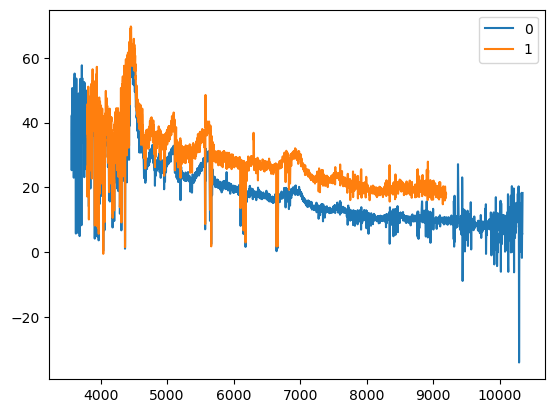

In [66]:
spec.select=0
plt.plot(spec.wavelength,spec.flux,label='0')
spec.select=1
plt.plot(spec.wavelength,spec.flux,label='1')
spec.select=2
#plt.plot(spec.wavelength,spec.flux)
#plt.ylim(-1,3)
plt.legend()


In [8]:
snr_file = rpath + 'dr14_median_snr.pckl'
median_snr = pickle.load(open(snr_file,'rb'))
index_snr = np.array([i for i,snr in enumerate(median_snr) if snr>=20])
meta_snr = [median_snr[i] for i in index_snr]

crossmatch = set(index_snr).intersection(index_z)
index_final = list(crossmatch)
index_final.sort()

snr_final = [median_snr[idx] for idx in index_final]
z_final = [meta[idx][6] for idx in index_final]
print(len(snr_final),len(z_final))

meta_final = igmsp['BOSS_DR14'].meta_from_ids(np.array(index_final), first=False)

meta_final[0:3]

coords = SkyCoord(meta_final[1000][0], meta_final[1000][1],unit='deg')
print(coords)
meta_sing = igmsp.meta_from_position(coords, 1*u.arcsec)
print('-----')
spec = igmsp.spectra_from_meta(meta_sing)
print('Nspec = {:d}'.format(spec.nspec))
spec.wavelength[1]
#spec.select = 0

#fig, ax = plt.subplots()
#fig.set_figwidth(15)
#ax.plot(spec.wavelength,spec.flux, lw=1,c='black')
#ax.plot(z_final,snr_final,'.')
#spectra = igmsp.spectra_from_meta(meta_final)

2502 2502
<SkyCoord (ICRS): (ra, dec) in deg
    (170.6353807, 19.76280377)>
Your search yielded 1 match[es] within radius=1 arcsec
-----
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Nspec = 2


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


<Quantity 3603.29638672 Angstrom>

In [30]:
a = [1,2,3,4,5,6,7,8]
a[3:6]


[4, 5, 6]

In [95]:
#count = []
#for object in meta_final:
#    coords = SkyCoord(object[0], object[1],unit='deg')
#    meta_sing = igmsp.meta_from_position(coords, 1*u.arcsec)
#    spec = igmsp.spectra_from_meta(meta_sing)
#    count.append(spec.nspec)
counts, bins = np.histogram(count)
#print(counts)
#bins = [0,1,2,3,4,5,6,7,8,9]
#counts = [ 857 ,1483 , 113  , 23  ,     14  ,  4  ,  4  ,  3   , 1]
#plt.stairs(counts, bins)
plt.hist(count)
plt.yscale('log')
#print(count)

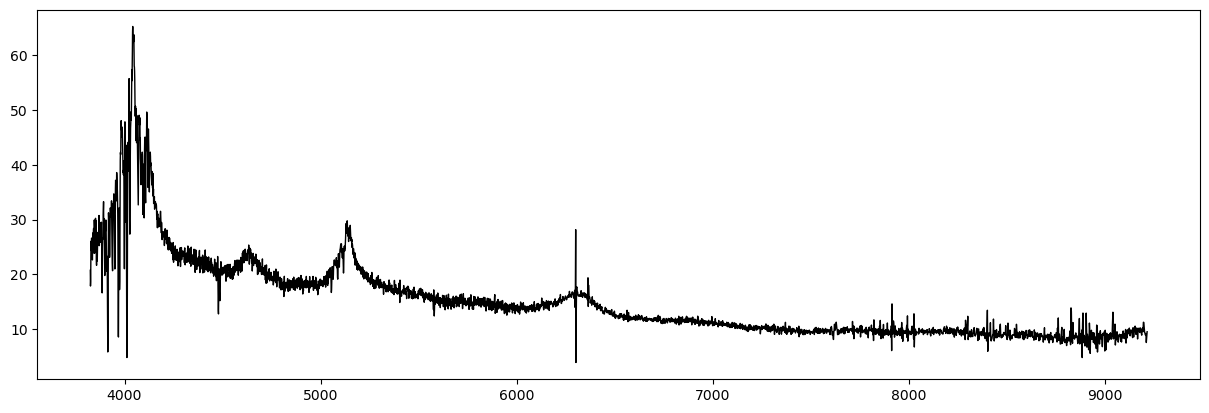

In [65]:
spec.select = 1

fig, ax = plt.subplots()
fig.set_figwidth(15)
ax.plot(spec.wavelength,spec.flux, lw=1,c='black')

In [10]:
meta[46788]


RA_GROUP,DEC_GROUP,THING_ID,PLATE,MJD,FIBERID,Z,Z_ERR,Z_VI,Z_PIPE,Z_PIPE_ERR,ZWARNING,Z_PCA,Z_PCA_ER,Z_MGII,BOSS_TARGET1,ANCILLARY_TARGET1,ANCILLARY_TARGET2,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,N_SPEC_SDSS,N_SPEC_BOSS,N_SPEC,PLATE_DUPLICATE,MJD_DUPLICATE,FIBERID_DUPLICATE,BI_CIV,ERR_BI_CIV,RUN_NUMBER,COL_NUMBER,FIELD_NUMBER,PSFFLUX,IVAR_PSFFLUX,PSFMAG,ERR_PSFMAG,MI,GAL_EXT,RASS_COUNTS,RASS_COUNTS_SNR,SDSS2ROSAT_SEP,FLUX_0.2_2.0keV,FLUX_0.2_2.0keV_ERR,FLUX_2.0_12.0keV,FLUX_2.0_12.0keV_ERR,FLUX_0.2_12.0keV,FLUX_0.2_12.0keV_ERR,LUM_0.2_12.0keV,SDSS2XMM_SEP,GALEX_MATCHED,FUV,FUV_IVAR,NUV,NUV_IVAR,JMAG,ERR_JMAG,JSNR,JRDFLAG,HMAG,ERR_HMAG,HSNR,HRDFLAG,KMAG,ERR_KMAG,KSNR,KRDFLAG,SDSS2MASS_SEP,W1MAG,ERR_W1MAG,W1SNR,W1CHI2,W2MAG,ERR_W2MAG,W2SNR,W2CHI2,W3MAG,ERR_W3MAG,W3SNR,W3CHI2,W4MAG,ERR_W4MAG,W4SNR,W4CHI2,SDSS2WISE_SEP,UKIDSS_MATCHED,YFLUX,YFLUX_ERR,JFLUX,JFLUX_ERR,HFLUX,HFLUX_ERR,KFLUX,KFLUX_ERR,FIRST_MATCHED,FIRST_FLUX,FIRST_SNR,SDSS2FIRST_SEP,ORIG_ID,R,zem_GROUP,sig_zem,IGM_ID,NPIX,WV_MIN,WV_MAX,GROUP_ID,EPOCH,SDSS_NAME,SPECTRO,SOURCE_Z,SPECTRO_DUPLICATE,RERUN_NUMBER,OBJ_ID,CC_FLAGS,PH_FLAGS,flag_zem,CAT,DATE-OBS,INSTR,DISPERSER,TELESCOPE,STYPE,SPEC_FILE
float64,float64,int32,int16,int32,int16,float64,float64,float64,float64,float64,int16,float64,float64,float64,int64,int64,int64,int64,int64,int64,int16,int16,int16,int32[51],int32[51],int32[51],float64,float64,int16,int16,int16,float64[5],float64[5],float64[5],float64[5],float64,float64[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float32,int16,float64,float64,float32,int16,float64,float64,float32,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,int64,float64,str18,str4,str4,str1[51],str1,str1,str4,str4,str4,str4,str10,str4,str4,str10,str3,str26
18.67261,-3.80307,50881629,7045,56577,874,1.06,0.0,1.0599999427795408,1.0598642826080322,0.0007009705295786263,0,1.0593685,1.0598188999999998,1.0598188999999998,0,0,1024,0,0,0,0,0,0,-1 .. -1,-1 .. -1,-1 .. -1,0.0,0.0,0,0,0,0.9970155358314514 .. 4.698693752288818,13.02229118347168 .. 1.352277159690857,22.482444763183594 .. 20.794076919555664,0.29053208231925964 .. 0.1895279884338379,-23.201591,0.22649551928043365 .. 0.0674838051199913,0.0,0.0,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,1.0,0.0390310063958168,52.325171632742965,0.7281230092048645,160.80422402778598,nan,nan,nan,-1,nan,nan,nan,-1,nan,nan,nan,-1,nan,16.822,0.105,10.300000190734863,0.9982,15.9,0.16699999999999998,6.5,0.9135,12.049,nan,1.2000000476837158,0.9104,8.922,0.105,2.0999999046325684,0.9287,0.614661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.0,-1.0,-1.0,49068,2100.0,1.060,0.0007009705295786263,46788,4592,3609.1,10387.2,46788,2000.0,011441.42-034811.0,BOSS,VI,- .. -,-,-,0000,ABUC,VI,DR14,2013-10-12,BOSS,BOTH,SDSS 2.5-M,QSO,spec-7045-56577-0874.fits


In [16]:
meta[154][27]


10207.619

In [33]:
dpath= '/media/bartosz/Volume/BOSS_DR14/data/'

nn = np.loadtxt(dpath + 'nearest_neighbors.txt')

idx = nn[:,0]

nn_idx = nn[:,2:7]
#nn0_d,nn1_d,nn2_d,nn3_d,nn4_d,nn5_d = nn[:,8],nn[:,9],nn[:,10],nn[:,11],nn[:,12]
nn_d = nn[:,8:13]


d_mean = np.array([np.mean(d) for d in nn_d])
Counter([j for i in nn_idx for j in i])

Counter({110799.0: 24,
         327423.0: 19,
         193470.0: 18,
         229201.0: 17,
         391635.0: 17,
         405124.0: 17,
         439311.0: 17,
         118761.0: 17,
         275281.0: 17,
         220749.0: 17,
         289049.0: 17,
         284784.0: 17,
         309055.0: 16,
         393772.0: 16,
         128283.0: 16,
         167528.0: 16,
         294745.0: 16,
         364057.0: 15,
         320303.0: 15,
         104001.0: 15,
         443507.0: 15,
         186174.0: 15,
         140248.0: 15,
         256378.0: 15,
         115439.0: 15,
         420612.0: 15,
         438405.0: 15,
         228440.0: 15,
         391964.0: 15,
         32175.0: 15,
         95201.0: 15,
         383901.0: 15,
         311272.0: 14,
         285946.0: 14,
         397487.0: 14,
         8843.0: 14,
         282607.0: 14,
         281331.0: 14,
         372307.0: 14,
         381529.0: 14,
         407046.0: 14,
         205383.0: 14,
         173192.0: 14,
         245591

3.2926211607494027
2.894843370402808
3.3662953156318602
2.4431067452999544
2.5490854743088986
2.7303089856018503
2.381585787322435
2.7398096138307544
2.684006693875005
2.9890508037928267
2.884794428492129
2.938879842011463
3.3672769176039354
1.9809897097852482
2.958584055388026
3.0746073254729693
3.070203034943984
3.020589456471529
2.6850994792935063
2.588427866730351
2.458309373801697
2.795218116324117
2.920899323279993
3.246793545243526


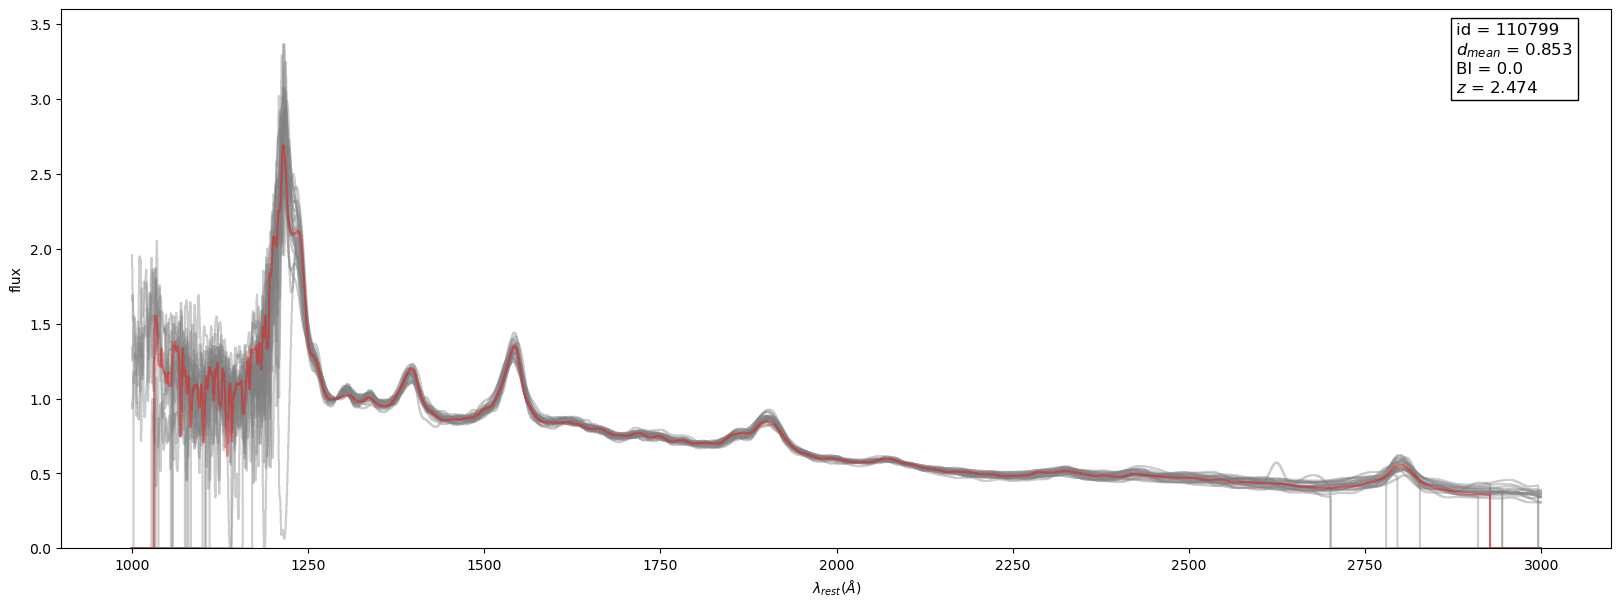

In [46]:
dpath= '/media/bartosz/Volume/BOSS_DR14/data/'

nn = np.loadtxt(dpath + 'nearest_neighbors.txt')

idx = nn[:,0]

nn_idx = nn[:,2:7]

bestN = 110799
bestNNs = [idx[i] for i,nn in enumerate(nn_idx) if bestN in nn]

fig, ax = plt.subplots(figsize=(20,7))

#specfiles = [fname for fname in glob.glob(dpath + 'fits/dpx25/' + '{}_*.txt'.format(index)) for index in bestNNs]
specfiles = [glob.glob(dpath + 'fits/dpx25/' + '{}_*.txt'.format(int(index))) for index in bestNNs]

#print(specfiles)
for fname in specfiles:
    spec = np.loadtxt(*fname)
    wl = spec[:,0]
    flux = spec[:,1]
    #print(wl)
    print(max(flux))
    ax.plot(wl,spec, c='grey', alpha=0.4,drawstyle='steps-mid')

    #plt.show()
    #break

spec = np.loadtxt(dpath+'fits/dpx25/' + '110799_spec-3690-55182-272_0_dpx25.txt')
wl = spec[:,0]
flux = spec[:,1]
ax.plot(wl,spec, c='red', alpha=0.4,drawstyle='steps-mid')
#ax.set_ylim(0.3,1.7)
#ax.set_xlim(1250,2250)
ax.set_ylim(0,3.6)
ax.set_xlabel('$\lambda_{rest} (\AA)$')
ax.set_ylabel('flux')

qdmean=d_mean[399]
z, BI = get_z(meta,bestN), get_BI(meta,bestN)
info = '\n'.join((
    r'id = {}'.format(bestN),
    r'$d_{{mean}}$ = {0:.3f}'.format(qdmean),
    r'BI = {0:.1f}'.format(BI),
    r'$z$ = {0:.3f}'.format(z)))

props = dict(boxstyle='square', facecolor='white')
ax.text(0.9, 0.975, info, transform=ax.transAxes, fontsize=12,
    verticalalignment='top', bbox=props)
plt.savefig('plots/110799_NN.png', format='png')
plt.show()

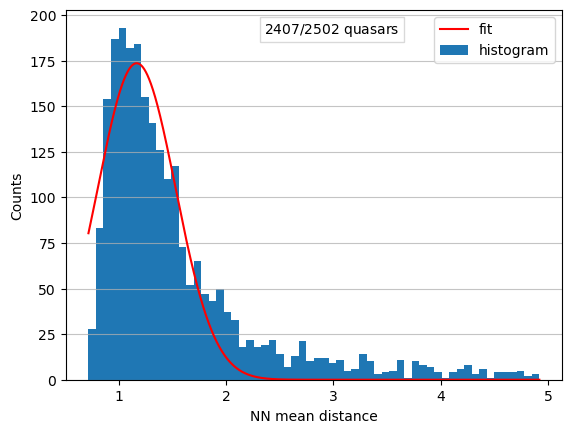

In [7]:
ihist = d_mean <5
counts,bins= np.histogram(d_mean[ihist],bins=60)

nn1 = nn_d[:,0]
hist1 = nn1 < 10
counts1,bins1 = np.histogram(nn1[hist1],bins=60)


fig, ax = plt.subplots()
#plt.hist(bins[:-1],bins,weights=counts,histtype='step',label='NN mean')
#plt.hist(bins1[:-1],bins1,weights=counts1,histtype='step',label='1st NN')

info = ''.join(
    r'${}/{}$ quasars'.format(np.sum(counts),len(d_mean)))

props = dict(boxstyle='square', facecolor='white', alpha=0.15)
ax.text(0.4, 0.97, info, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

def halfgaussian(x, mean, amplitude, standard_deviation):
    y = np.empty_like(x)
    mask1 = x<0.76
    mask2 = x>=0.76
    y[mask1] = 0
    y[mask2] = amplitude * np.exp( - (x[mask2] - mean)**2 / (2*standard_deviation ** 2))
    return y


def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return scipy.stats.poisson.pmf(k, lamb)

#bin_heights, bin_borders = np.histogram(x, bins='auto')
bin_widths = np.diff(bins)
bin_centers = bins[:-1] + bin_widths / 2
t_init = models.Gaussian1D()
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, bin_centers, counts)

# fit with curve_fit
parameters, cov_matrix = curve_fit(halfgaussian, bin_centers, counts)

# plot poisson-deviation with fitted parameter
x_plot = np.arange(1, 10)

# plt.plot(
#     x_interval_for_fit,
#     halfgaussian(x_interval_for_fit, *parameters),
#     color='orange',linestyle='-', marker='',
#     label='Fit result',
# )

x_interval_for_fit = np.linspace(bins[0], bins[-1], 10000)
plt.bar(bin_centers, counts, width=bin_widths, label='histogram')
plt.plot(x_interval_for_fit, t(x_interval_for_fit), label='fit', c='red')
plt.legend()

plt.xlabel('NN mean distance')
plt.ylabel('Counts')
#plt.xlim(0,10)
#plt.yscale('log')

plt.grid(axis='y', alpha=0.75)
plt.savefig('plots/distr_dmean.png',format='png')
plt.show()

In [214]:
fpath= '/media/bartosz/Volume/BOSS_DR14/data/fits/dpx25/'



for filename in glob.glob(fpath+'57492_*.txt'):
    nn0 = np.loadtxt(filename)[:,1]
    x = np.loadtxt(filename)[:,0]

mask1 = x>1250 
mask2 = x<2250
mask = np.logical_and(mask1,mask2)
for filename in glob.glob(fpath+'30859_*.txt'):
    nn1 = np.loadtxt(filename)[:,1]

for filename in glob.glob(fpath+'378558_*.txt'):
    nn2 = np.loadtxt(filename)[:,1]

for filename in glob.glob(fpath+'288095_*.txt'):
    nn3 = np.loadtxt(filename)[:,1]

for filename in glob.glob(fpath+'174086_*.txt'):
    nn4 = np.loadtxt(filename)[:,1]

for filename in glob.glob(fpath+'231777_*.txt'):
    nn5 = np.loadtxt(filename)[:,1]

np.sqrt(np.sum([f*f for f in nn0[mask]-nn2[mask]]))

1.4320375751637204

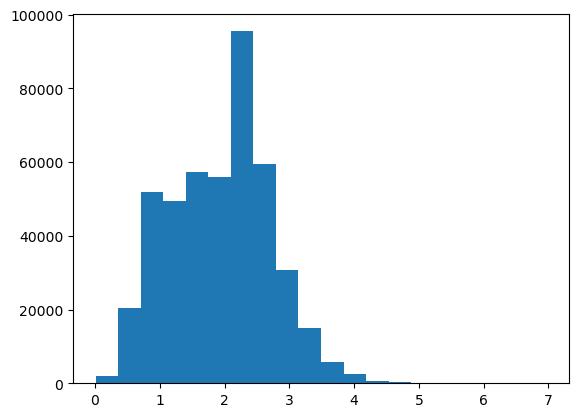

In [105]:
Z = [m[6] for m in meta]# if 0<=m[6]<=5]
len(Z)
Zcounts,Zbins= np.histogram(Z,bins=20)

plt.hist(Zbins[:-1],Zbins,weights=Zcounts)
plt.show()

In [26]:
sum(1 for i in J if not np.isnan(i))

440512

In [34]:
Q = [i for i,m in enumerate(meta) if 0.66<=m[6]<=1.55 and all(j<22 for j in m[34])]
len(Q)

107469

In [87]:
J = [[m[6],m[54]] for m in meta if not np.isnan(m[54])]
Jband = [j for j in J if 0.66<=j[0]<=1.55 and j[1]<22]
jband = [e[1] for e in Jband]
jred = [e[0] for e in Jband]

with open('data/z_Jmag.txt', 'w') as Jsave:
    lst = [jred,jband]
    for x in zip(*lst):
        Jsave.write('{} \t {} \n'.format(*x))
Jsave.close()

len(Jband)

1739

In [88]:
iband = [m[34][3] for i,m in enumerate(meta) if 0.66<=m[6]<=1.55 and m[34][3]<22]
ired = [m[6] for i,m in enumerate(meta) if 0.66<=m[6]<=1.55 and m[34][3]<22]

with open('data/z_imag.txt', 'w') as isave:
    lst = [ired,iband]
    for x in zip(*lst):
        isave.write('{} \t {} \n'.format(*x))
isave.close()
len(iband)

129191

In [5]:
zband = [m[34][4] for i,m in enumerate(meta) if 0.1<=m[6]<=2.1 and m[34][4]<23]
zred = [m[6] for i,m in enumerate(meta) if 0.1<=m[6]<=2.1 and m[34][4]<23]

with open('data/z_zmag_2.txt', 'w') as zsave:
    lst = [zred,zband]
    for x in zip(*lst):
        zsave.write('{} \t {} \n'.format(*x))
zsave.close()
len(zband)

237150

In [33]:
sel = [[1.36 ,   18.852691650390625],
[1.432 ,  19.116455078125],
[0.93537974 , 20.624008178710938],
[0.84656364 , 21.034252166748047],
[1.058345  ,  17.828460693359375],
[1.0724703000000002 , 19.293384552001953],
[0.7883223  , 20.33251190185547],
[1.485 ,  21.397701263427734],
[1.2283605  , 18.967636108398438],
[0.753   ,19.83353614807129],
[1.4477440000000001 , 20.895225524902344],
[0.858 ,  21.715391159057617]]

sel_info=[]
for i,m in enumerate(meta):
    obj = [m[6],m[34][4]]
    if obj in sel:
        RA, DEC, Z, zAB, idx = m[0],m[1],m[6],m[34][4],i
        coords = SkyCoord(RA,DEC,unit='deg')
        sel_info.append([RA, DEC, Z, zAB, idx])

        meta_sing = igmsp.meta_from_position(coords, 1*u.arcsec)
        spec = igmsp.spectra_from_meta(meta_sing)
        
        fig, ax = plt.subplots(figsize=(20,7))
        
        ax.plot(spec.wavelength,spec.flux, lw=2,c='black',drawstyle='steps-mid')
        plt.plot(spec.wavelength,spec.sig,linewidth=1,drawstyle='steps-mid', color='grey')

        info = '\n'.join((
            r'RA = {}'.format(RA),
            r'DEC = {}'.format(DEC),
            r'z = {}'.format(Z),
            r'z AB mag = {}'.format(zAB)))

        props = dict(boxstyle='square', facecolor='lightblue', alpha=0.5)
        ax.text(0.7, 0.95, info, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        
        plt.savefig('plots/spec{}.png'.format(idx),format='png')
        plt.close()
        

Your search yielded 1 match[es] within radius=1 arcsec
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Your search yielded 1 match[es] within radius=1 arcsec
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Your search yielded 1 match[es] within radius=1 arcsec
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Your search yielded 1 match[es] within radius=1 arcsec
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Your search yielded 1 match[es] within radius=1 arcsec
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Your search yielded 1 match[es] within radius=1 arcsec
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Your search yielded 1 match[es] within radius=1 arcsec
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Your search yielded 1 match[es] within radius=1 arcsec
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Your search yielded 1 match[es] within radius=1 arcsec
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Your search yielded 1 match[es] within radius=1 arcsec
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Your search yielded 1 match[es] within radius=1 arcsec
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Your search yielded 1 match[es] within radius=1 arcsec
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


In [24]:
with open('data/selection_info.txt', 'w') as zsave:
    lst = sel_info
    for x in lst:
        zsave.write('{} \t {} \t {} \t {} \t {} \n'.format(*x))
zsave.close()

In [20]:
sel_info

[[1.36, 0.005316971570891838, -2.033273291001564, 18.852691650390625, 5],
 [0.93537974, 0.006143972596646563, 21.276711551497108, 20.624008178710938, 8],
 [0.84656364,
  0.008585837127839113,
  19.404917448393988,
  21.034252166748047,
  18],
 [0.7883223, 0.010430687323889742, 2.3052534587317464, 20.33251190185547, 24],
 [1.485, 0.013630253212241428, 0.1924486786871756, 21.397701263427734, 30],
 [1.4477440000000001,
  0.01592769507868752,
  25.0952833873808,
  20.895225524902344,
  36],
 [0.858, 0.01994309883036749, -0.90963485118292, 21.715391159057617, 44],
 [1.432, 0.038657366027280204, 2.1061119205856427, 19.116455078125, 91],
 [1.0724703000000002,
  0.04206465365706436,
  19.7915089514002,
  19.293384552001953,
  101],
 [0.753, 0.04480456261075005, -5.722222936052879, 19.83353614807129, 110],
 [1.058345, 0.10294420484319744, 5.973508404292357, 17.828460693359375, 270],
 [1.2283605, 0.1050844158781956, 5.7718080767970354, 18.967636108398438, 275]]

In [62]:
nonzeros = [i for i in zband if i!=0]
len(nonzeros)
inonzeros= [i for i in iband if i!=0]
len(inonzeros)

128911

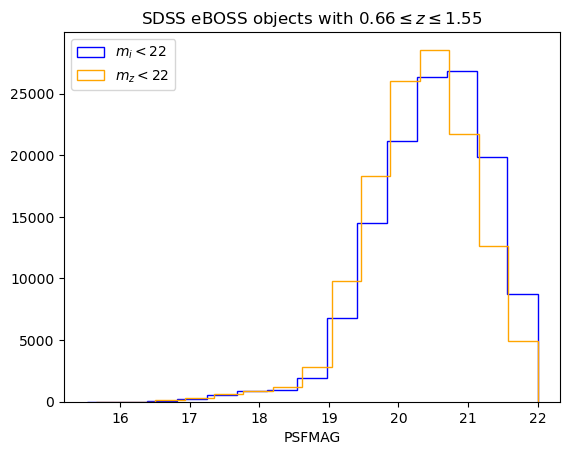

In [77]:
fig, ax = plt.subplots()

counts, bins = np.histogram(nonzeros,bins=15)
icounts,ibins= np.histogram(inonzeros,bins=15)

ax.hist(ibins[:-1],ibins,weights=icounts,color='blue',histtype='step',label='$m_{i}<22$')
ax.hist(bins[:-1], bins, label='$m_{z}<22$', weights=counts, histtype='step', color='orange')

#plt.hist(nonzeros,label='SDSS EBOSS objects with $z_{mag}<22$')
plt.xlabel('PSFMAG')
plt.ylabel('')
plt.legend()
plt.title('SDSS eBOSS objects with $0.66 \leq z \leq 1.55$')
plt.savefig('plots/z_i_band_hist.png',format='png')
plt.show()

In [41]:
for i,m in enumerate(meta):
    if 0.66<=m[6]<=1.55 and np.mean(m[34])<22:
        break;
meta[i][34]

array([20.59112358, 19.9791832 , 19.22360611, 18.95267105, 18.85269165])

In [6]:
meta = igmsp['BOSS_DR14'].meta
qdict = { 'Z':(2,3)}
print(len(meta))
#print(meta[1][81])
#meta[0:10]
#spectra = igmsp.spectra_from_meta(meta)
qmeta = igmsp.query_meta(qdict)
qmeta[0:3]
#len(qmeta)

#snr_file = rpath + 'dr14_median_snr.pckl'
#median_snr = pickle.load(open(snr_file,'rb'))
#len(median_snr)
#index=[]
#for i,snr in enumerate(median_snr):
#    if snr >= 20:
#        index.append(i)

#meta_z = [meta[j] for j in index]


#spectra = igmsp.spectra_from_meta(qmeta)

446844


RA_GROUP,DEC_GROUP,THING_ID,PLATE,MJD,FIBERID,Z,Z_ERR,Z_VI,Z_PIPE,Z_PIPE_ERR,ZWARNING,Z_PCA,Z_PCA_ER,Z_MGII,BOSS_TARGET1,ANCILLARY_TARGET1,ANCILLARY_TARGET2,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,N_SPEC_SDSS,N_SPEC_BOSS,N_SPEC,PLATE_DUPLICATE,MJD_DUPLICATE,FIBERID_DUPLICATE,BI_CIV,ERR_BI_CIV,RUN_NUMBER,COL_NUMBER,FIELD_NUMBER,PSFFLUX,IVAR_PSFFLUX,PSFMAG,ERR_PSFMAG,MI,GAL_EXT,RASS_COUNTS,RASS_COUNTS_SNR,SDSS2ROSAT_SEP,FLUX_0.2_2.0keV,FLUX_0.2_2.0keV_ERR,FLUX_2.0_12.0keV,FLUX_2.0_12.0keV_ERR,FLUX_0.2_12.0keV,FLUX_0.2_12.0keV_ERR,LUM_0.2_12.0keV,SDSS2XMM_SEP,GALEX_MATCHED,FUV,FUV_IVAR,NUV,NUV_IVAR,JMAG,ERR_JMAG,JSNR,JRDFLAG,HMAG,ERR_HMAG,HSNR,HRDFLAG,KMAG,ERR_KMAG,KSNR,KRDFLAG,SDSS2MASS_SEP,W1MAG,ERR_W1MAG,W1SNR,W1CHI2,W2MAG,ERR_W2MAG,W2SNR,W2CHI2,W3MAG,ERR_W3MAG,W3SNR,W3CHI2,W4MAG,ERR_W4MAG,W4SNR,W4CHI2,SDSS2WISE_SEP,UKIDSS_MATCHED,YFLUX,YFLUX_ERR,JFLUX,JFLUX_ERR,HFLUX,HFLUX_ERR,KFLUX,KFLUX_ERR,FIRST_MATCHED,FIRST_FLUX,FIRST_SNR,SDSS2FIRST_SEP,ORIG_ID,R,zem_GROUP,sig_zem,IGM_ID,NPIX,WV_MIN,WV_MAX,GROUP_ID,EPOCH,SDSS_NAME,SPECTRO,SOURCE_Z,SPECTRO_DUPLICATE,RERUN_NUMBER,OBJ_ID,CC_FLAGS,PH_FLAGS,flag_zem,CAT,DATE-OBS,INSTR,DISPERSER,TELESCOPE,STYPE,SPEC_FILE,GROUP
float64,float64,int32,int16,int32,int16,float64,float64,float64,float64,float64,int16,float64,float64,float64,int64,int64,int64,int64,int64,int64,int16,int16,int16,int32[51],int32[51],int32[51],float64,float64,int16,int16,int16,float64[5],float64[5],float64[5],float64[5],float64,float64[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float32,int16,float64,float64,float32,int16,float64,float64,float32,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,int64,float64,str18,str4,str4,str1[51],str1,str1,str4,str4,str4,str4,str10,str4,str4,str10,str3,str26,str9
0.00190,17.77374,268270422,7596,56945,162,2.309,0.0,2.309000015258789,2.307750701904297,0.0010300044668838382,0,2.3045657000000004,-1.0,-1.0,0,0,0,0,4096,0,0,1,1,0 .. -1,0 .. -1,0 .. -1,0.0,0.0,0,0,0,1.0379366874694824 .. 2.631136417388916,12.372532844543457 .. 0.8706143498420715,22.440338134765625 .. 21.372461318969727,0.2871243953704834 .. 0.38545534014701843,-24.410782,0.12021728605031967 .. 0.03581845760345459,0.0,0.0,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,1.0,0.30231887102127075,8.785573140381722,0.7275648713111877,4.537358964921044,nan,nan,nan,-1,nan,nan,nan,-1,nan,nan,nan,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,-1.0,-1.0,-1.0,0,2100.0,2.309,0.0010300044668838382,0,3510,3566.2,8000.2,0,2000.0,000000.45+174625.4,BOSS,VI,- .. -,-,-,,,VI,DR14,2014-10-15,BOSS,BOTH,SDSS 2.5-M,QSO,spec-7596-56945-0162.fits,BOSS_DR14
0.00238,5.94190,163544156,8740,57367,694,2.1031202999999996,0.0,-1.0,2.1031203269958496,0.0009241577354259787,0,2.0996384999999997,2.0983490000000002,2.0983490000000002,0,0,0,0,2048,0,0,0,0,-1 .. -1,-1 .. -1,-1 .. -1,0.0,0.0,0,0,0,1.1197296380996704 .. 4.730101585388184,9.196866035461426 .. 0.8192309737205505,22.360628128051758 .. 20.78717613220215,0.3101848363876343 .. 0.2420300394296646,-24.732,0.2338263988494873 .. 0.06966802477836609,0.0,0.0,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,0.0,0.0,0.0,nan,nan,nan,-1,nan,nan,nan,-1,nan,nan,nan,-1,nan,16.969,0.127,8.5,0.9904,16.887999999999998,0.409,2.700000047683716,1.004,11.861,nan,1.399999976158142,0.9819,8.604,0.127,0.699999988079071,0.9478,0.706171,1.0,1.2885136657753169e-31,2.4790984841010035e-32,1.229889058862803e-31,4.504542253745802e-32,1.496424644649041e-31,4.7290496259357616e-32,2.4598190249290145e-31,5.689571920868372e-32,0,-1.0,-1.0,-1.0,1,2100.0,2.103,0.0009241577354259787,1,4582,3619.9,10394.4,1,2000.0,000000.57+055630.8,

In [43]:
a = [3,7,1,6,2,3,7,9,4,5,1]
b = [a[i] for i in [1,4,6,7]]
b
index = [a.index(x) for x in b]
len(index) != len(set(index))

True

In [9]:
qso1, qso2, qso3 = [5852,56034,900], [6460,56334,170], [6425,56298,840]
pos1, pos2, pos3 = ['123056.96+175139.5'], [' 101003.95+332625.6'], ['103411.89+234525.3']
#pos=np.array(['123056.96+175139.5', '101003.95+332625.6', '103411.89+234525.3'])
qdict = dict(SPECTRO='BOSS')

In [10]:
#test = igmsp.meta_from_position(pos1, 1*u.arcsec)
spec, meta = igmsp.spectra_from_coord(pos1, meta_query=qdict)

Your search yielded 1 match[es] within radius=0.5 arcsec
Staged 1 spectra totalling 7.456e-05 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Text(0.62, 0.95, 'thing_ID: 268645346\nplate: 5852\nmjd: 56034\nfiber: 900')

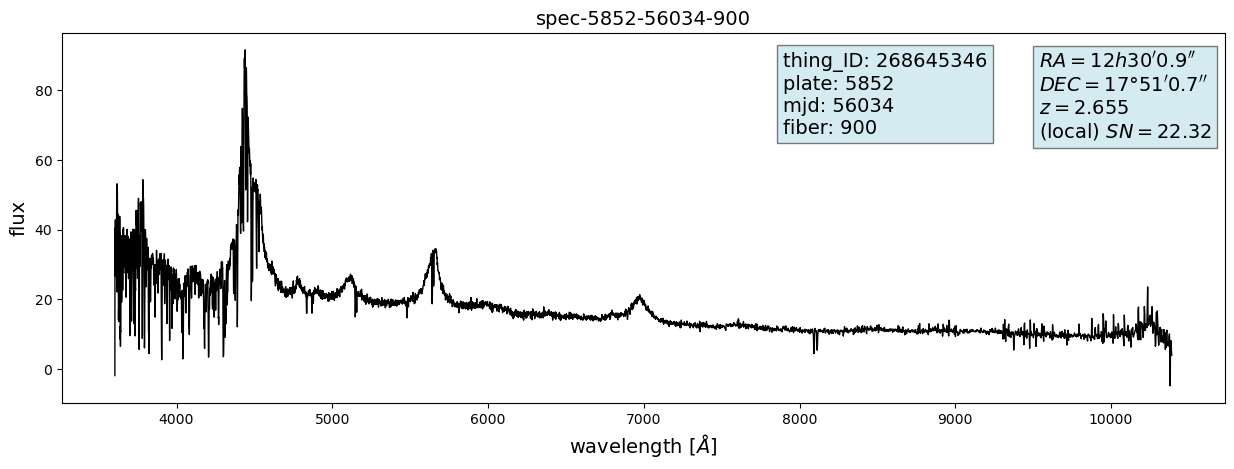

In [11]:
obj = meta[0]

array_wl,array_flux,array_sig=spec.wavelength,spec.flux,spec.sig
plate,mjd,fiber = obj[3],obj[4],obj[5]
ra,dec,z=obj[0],obj[1],obj[6]
s2n=spec.get_local_s2n(spec.wavelength[2250],npix=4581)[0]
thing_id = obj[2]
file_save='spec-{}-{}-{}'.format(plate,mjd,fiber)
f=open(rpath + 'data/' + file_save + '.txt','w')
for j in range(len(array_wl)):
    wl,flux,sig=array_wl[j],array_flux[j],array_sig[j]
    f.write('{}\t{}\t{}\n'.format(wl,flux,sig))
f.close()

fig, ax = plt.subplots()

ax.plot(array_wl,array_flux, lw=1,c='black')
ax.set_title('{}'.format(file_save), fontsize=14)
ax.set_xlabel('wavelength $[\AA]$',fontsize=14)
ax.set_ylabel('flux',fontsize=14)
fig.set_figwidth(15)
info1 = '\n'.join((
    r'$RA= {}$'.format(degtohms(ra)),
    r'$DEC={}$'.format(degtodegms(dec)),
    r'$z={0:.3f}$'.format(z),
    r'(local) $SN={0:.2f}$'.format(s2n)))
info2 = '\n'.join((
    r'thing_ID: {}'.format(thing_id),
    r'plate: {}'.format(plate),
    r'mjd: {}'.format(mjd),
    r'fiber: {}'.format(fiber)))

props = dict(boxstyle='square', facecolor='lightblue', alpha=0.5)
ax.text(0.84, 0.95, info1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.62, 0.95, info2, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#plt.savefig(rpath + 'plots/{}.png'.format(file_save), format='png')
#plt.close()

In [12]:
spec.wavelength[1000]
spec.get_local_s2n(spec.wavelength[3000],npix=4581)

(22.312847, 6.605403)

In [13]:
len(spec.wavelength)


4599

In [14]:
import pickle

In [21]:
snr_file = rpath + 'dr14_median_snr.pckl'
median_snr = pickle.load(open(snr_file,'rb'))
len(median_snr)
i=0
for o in median_snr:
    if o>=20:
        i+=1
i

7847

In [27]:
a = [1,2,3,4,5,6,7]
b = [0,3,5]
c = [a[i] for i in b]
c

[1, 4, 6]

In [69]:
meta[1][56]
i=0
j=0
for o in meta:
#    if math.isnan(o[56]):
#        i+=1
    if o[56] >= 20:
        if o[6] >=2 and o[6] <=3:
        #print(o[56])
            j+=1
        
    else: i+=1
print(j)

38


In [41]:
ID ,info = [],[]
ra, dec = [],[]
for row in meta:
    if row[6] >= 2 and row[6] <= 3:
        if row[81] >= 20:
            plate = row[3]
            mjd = row[4]
            fiber = row[5]
            #name = row[0]
            ra.append(row[0])
            dec.append(row[1])
            redshift = row[6]
            #sn = row[10]
            #ID.append([plate, mjd, fiber])
            #info.append([ra, dec, redshift])

print(len(ra))

9


In [30]:
coord = SkyCoord(ra,dec,unit='deg')
coord[0:10]

<SkyCoord (ICRS): (ra, dec) in deg
    [(0.0073623 ,  -7.48592689), (0.03118942,  11.70188636),
     (0.03908585,  13.93845165), (0.05682287,  -2.17207369),
     (0.06036964, -10.75848229), (0.0626618 ,   6.74939813),
     (0.09558287,  -2.45457676), (0.12178082,   5.82018859),
     (0.12769617,  -6.68335491), (0.13040665,  -7.05327717)]>

In [55]:
#qdict = {'zem': (2.,3.), 'STYPE': 'QSO'}
#matches, sub_cat, IDs = igmsp.qcat.query_coords(coord,'QSO','BOSS_DR14')

In [22]:
#meta23 = igmsp['BOSS_DR14'].meta_from_ids(IDs,first=False)
#meta23[0][66

NameError: name 'IDs' is not defined

In [31]:
#spectra = igmsp.spectra_from_meta(meta23)
spec, meta= igmsp.spectra_in_group(coord[0:10],'BOSS_DR14')

Your search yielded 10 matches in the catalog from 10 input coordinates
Final query yielded 10 matches with group meta data.
Staged 10 spectra totalling 0.0007456 Gb
Loaded spectra


/home/bartosz/linetools/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


In [32]:
sp = spec.copy()
sp.flux

<Quantity [-14.447938 ,  -2.4819846,  16.477226 , ...,   9.444257 ,
             2.101464 ,  -9.650521 ]>

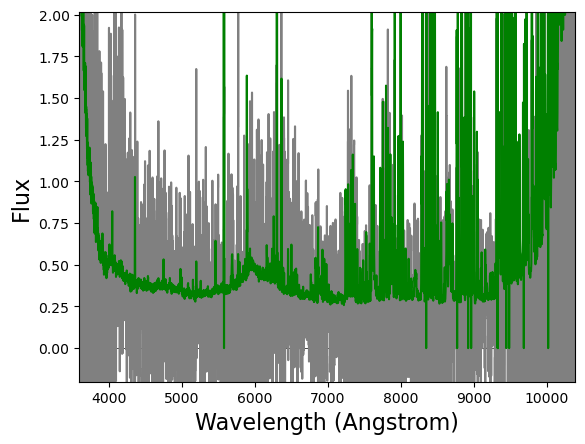

In [44]:
sp.select=3
sp.plot()
#sp.write('data/test.fits')